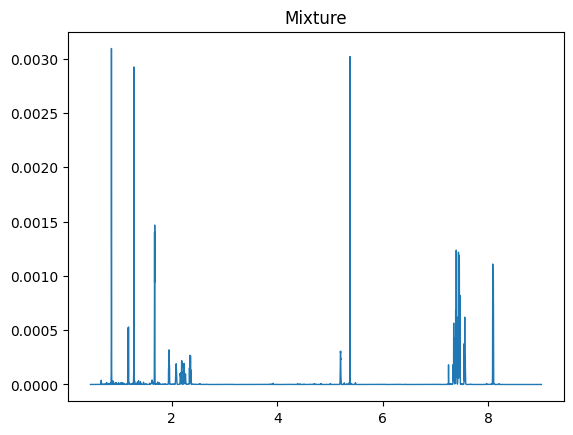

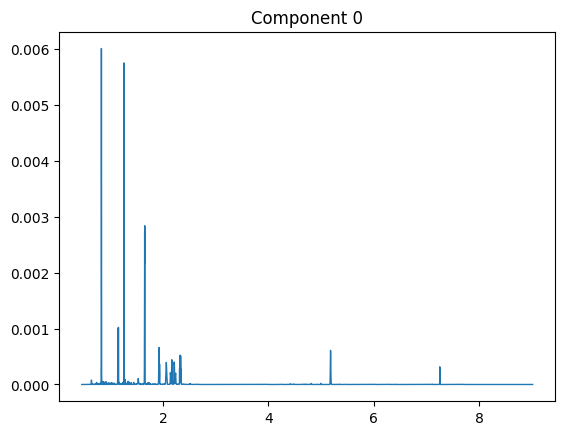

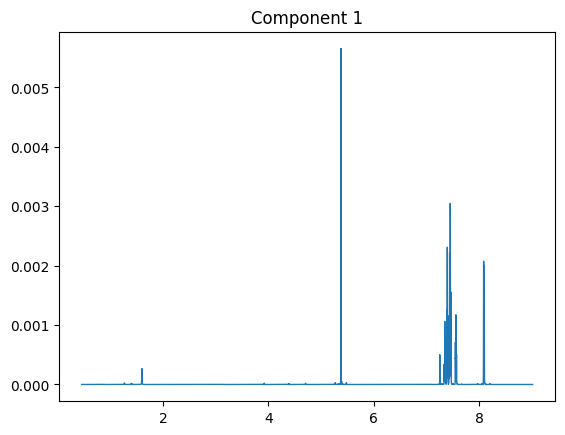

[(np.float64(0.457009), np.float64(1.528229306820996e-07)), (np.float64(0.457131), np.float64(1.2123352302240056e-07)), (np.float64(0.457253), np.float64(1.1059162033064253e-07)), (np.float64(0.457374), np.float64(9.99725490432446e-08)), (np.float64(0.457496), np.float64(9.365442068531171e-08)), (np.float64(0.457618), np.float64(8.733629232737883e-08)), (np.float64(0.457739), np.float64(1.2403407244641448e-07)), (np.float64(0.457861), np.float64(1.6073185256545014e-07)), (np.float64(0.457982), np.float64(2.3614336410202387e-07)), (np.float64(0.458104), np.float64(2.427302242599255e-07))]


In [23]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from wasserstein import Spectrum, NMRSpectrum

from typing import List
from matplotlib import pyplot as plt

import numpy as np

components_names = ["Pinene", "Benzyl benzoate"]

protons_list = [16, 12]

filename = "preprocessed_mix.csv"
mix = np.loadtxt(filename, delimiter=",")
# If you are using file exported from Mnova, comment line above and uncomment line below.
# mix = np.loadtxt(filename, delimiter='\t', usecols=[0,1])

how_many_components = len(components_names)
names = ["comp" + str(i) for i in range(how_many_components)]

files_with_components = ["preprocessed_comp0.csv", "preprocessed_comp1.csv"]
spectra = []
for i in range(how_many_components):
    filename = files_with_components[i]
    spectra.append(np.loadtxt(filename, delimiter=","))
    # If you are using file exported from Mnova, comment line above and uncomment line below.
    # spectra.append(np.loadtxt(filename, delimiter='\t', usecols=[0,1]))

spectra2: List[NMRSpectrum] = []
names = []
for i in range(len(spectra)):
    spectra2.append(
        NMRSpectrum(
            confs=list(zip(spectra[i][:, 0], spectra[i][:, 1])), protons=protons_list[i]
        )
    )
    names.append("comp" + str(i))

spectra = spectra2
del spectra2
mix = NMRSpectrum(confs=list(zip(mix[:, 0], mix[:, 1])))
mix.trim_negative_intensities()
mix.normalize()
for sp in spectra:
    sp.trim_negative_intensities()
    sp.normalize()
plt.title("Mixture")
mix.plot(profile=True)
for i, sp in enumerate(spectra):
    plt.title("Component " + str(i))
    sp.plot(profile=True)
print(spectra[0].confs[:10])

In [2]:
def filter_significant_features(first, second, n_features):
    """
    Select the n most significant features from both spectra.
    Uses combined intensity to determine importance.
    """
    # Create dictionary with combined intensities
    combined_intensities = {}
    for mz, prob in first.confs:
        combined_intensities[mz] = combined_intensities.get(mz, 0) + prob
    for mz, prob in second.confs:
        combined_intensities[mz] = combined_intensities.get(mz, 0) + prob

    # Select top n features
    selected_features = set(
        sorted(
            combined_intensities.keys(),
            key=lambda mz: combined_intensities[mz],
            reverse=True,
        )[:n_features]
    )

    # Filter spectra
    filtered_first = first.copy()
    filtered_first.confs = [
        (mz, prob) for mz, prob in first.confs if mz in selected_features
    ]

    filtered_second = second.copy()
    filtered_second.confs = [
        (mz, prob) for mz, prob in second.confs if mz in selected_features
    ]

    # Re-normalize
    filtered_first.normalize()
    filtered_second.normalize()

    return filtered_first, filtered_second


# Use only n most significant features
spectra_damped = [None, None]
spectra_damped[0], spectra_damped[1] = filter_significant_features(spectra[0], spectra[1], 2000)
distance = spectra_damped[0].WSDistance(spectra_damped[1])
# distance = WSDistance(spectra[0], spectra[1], n_features=2000)
difference = spectra[0].WSDistance(spectra[1]) - distance
print(distance)
print(difference)

gradient = spectra_damped[0].WSGradient(spectra_damped[1])
print(gradient)

5.427547742985783
-0.1563387001044685


Computing WSDistance gradient: 100%|██████████| 2000/2000 [00:11<00:00, 170.40it/s]

[0. 0. 0. ... 0. 0. 0.]


Mirror Descent (2 weights): 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]



Final weights:
  comp1 = 0.4644
  comp2 = 0.5356

Final Wasserstein distance to true mixture: 0.017554

Wasserstein distance for given mixture (0.393072, 0.606928): 0.370089


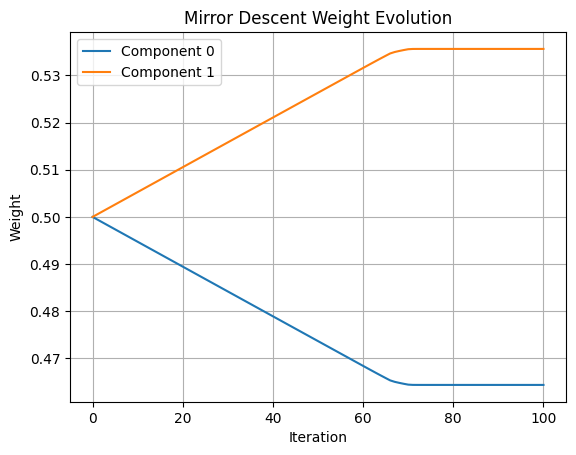

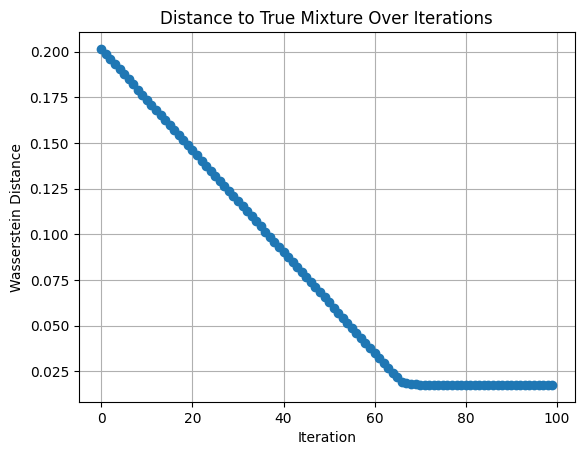

In [3]:
import matplotlib.pyplot as plt
from tqdm import trange

def calculate_gradient(mix, comp0, comp1, p, epsilon=1e-5):
    delta = epsilon

    p_plus = np.array([p[0] + delta, p[1] - delta])
    p_minus = np.array([p[0] - delta, p[1] + delta])

    p_plus = np.clip(p_plus, 1e-6, 1)
    p_plus /= p_plus.sum()

    p_minus = np.clip(p_minus, 1e-6, 1)
    p_minus /= p_minus.sum()

    sp_plus = Spectrum.ScalarProduct([comp0, comp1], p_plus)
    sp_minus = Spectrum.ScalarProduct([comp0, comp1], p_minus)

    sp_plus.normalize()
    sp_minus.normalize()

    grad = (mix.WSDistance(sp_plus) - mix.WSDistance(sp_minus)) / (2 * epsilon)

    # Gradient of p[1] is -grad because p[1] = 1 - p[0]
    grad_vec = np.array([grad, -grad])

    return grad_vec


def mirror_descent_two_weights(
    mix, comp0, comp1, learning_rate=1.0, T=100, epsilon=1e-5
):
    p = np.array([0.5, 0.5])  # start from uniform mixture
    history = [p.copy()]
    scores = []

    for _ in trange(T, desc="Mirror Descent (2 weights)"):
        # Track score (distance from current estimate to true mixture)
        estimated_mix = Spectrum.ScalarProduct([comp0, comp1], p)
        estimated_mix.normalize()
        ws = mix.WSDistance(estimated_mix)
        scores.append(ws)

        # Compute gradient
        grad_vec = calculate_gradient(mix, comp0, comp1, p, epsilon)

        # Mirror descent update
        w = p * np.exp(-learning_rate * grad_vec)
        p = w / w.sum()

        history.append(p.copy())

    return p, np.array(history), np.array(scores)


# Run mirror descent
# mix.normalize()
# spectra[0].normalize()
# spectra[1].normalize()

final_p, traj, score_history = mirror_descent_two_weights(
    mix, spectra[0], spectra[1], learning_rate=0.0002, T=100
)

# Reconstruct mixture from estimated weights
estimated_mix = Spectrum.ScalarProduct([spectra[0], spectra[1]], final_p)
estimated_mix.normalize()

# Compute Wasserstein distance to the actual mixture
ws_dist = mix.WSDistance(estimated_mix)

# Compute Wasserstein distance for the given mixture
given_p = np.array([0.393072, 0.606928])
given_mix = Spectrum.ScalarProduct([spectra[0], spectra[1]], given_p)
given_mix.normalize()
ws_dist_given = mix.WSDistance(given_mix)

# Print results
print("\nFinal weights:")
print(f"  comp1 = {final_p[0]:.4f}")
print(f"  comp2 = {final_p[1]:.4f}")
print(f"\nFinal Wasserstein distance to true mixture: {ws_dist:.6f}")
print(
    f"\nWasserstein distance for given mixture (0.393072, 0.606928): {ws_dist_given:.6f}"
)

plt.plot(traj[:, 0], label="Component 0")
plt.plot(traj[:, 1], label="Component 1")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.title("Mirror Descent Weight Evolution")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(score_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Wasserstein Distance")
plt.title("Distance to True Mixture Over Iterations")
plt.grid(True)
plt.show()


In [95]:
import torch

def numpy_to_torch_tensor(pairs):
    return {
        "values": torch.tensor([float(v) for v, _ in pairs], dtype=torch.float64, requires_grad=True),
        "probs": torch.tensor([float(p) for _, p in pairs], dtype=torch.float64, requires_grad=True)
    }

spectra_torch = [numpy_to_torch_tensor(sp.confs) for sp in spectra]
mix_torch = numpy_to_torch_tensor(mix.confs)

print(spectra_torch[0]["probs"][:10])
print(spectra_torch[0]["values"][:10])


tensor([1.5282e-07, 1.2123e-07, 1.1059e-07, 9.9973e-08, 9.3654e-08, 8.7336e-08,
        1.2403e-07, 1.6073e-07, 2.3614e-07, 2.4273e-07], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([0.4570, 0.4571, 0.4573, 0.4574, 0.4575, 0.4576, 0.4577, 0.4579, 0.4580,
        0.4581], dtype=torch.float64, grad_fn=<SliceBackward0>)


In [96]:
def weighted_quantile_torch(spectre, quantiles):
    # assume data normalized
    values, probs = spectre["values"], spectre["probs"]
    
    sorted_indices = torch.argsort(values)
    values = values[sorted_indices]
    probs = probs[sorted_indices]
    
    cum_probs = torch.cumsum(probs, dim=0)

    indices = torch.searchsorted(cum_probs, quantiles, right=True)
    indices = torch.clamp(indices, 0, len(values) - 1)
    quantile_values = values[indices]
    
    return quantile_values

data = spectra_torch[0]
quantiles = [0.25, 0.5, 0.75]
quantiles = torch.tensor(quantiles, dtype=torch.float64)
result = weighted_quantile_torch(data, quantiles)
print(result)

tensor([1.2226, 1.6497, 2.1389], dtype=torch.float64, grad_fn=<IndexBackward0>)


In [97]:
def wasserstein_distance(mu, nu, p=1):
    _, mu_probs = mu["values"], mu["probs"]
    _, nu_probs = nu["values"], nu["probs"]

    cum_probs_mu = torch.cumsum(mu_probs, dim=0)
    cum_probs_nu = torch.cumsum(nu_probs, dim=0)
    
    t = torch.cat([cum_probs_mu, cum_probs_nu])
    t, _ = torch.sort(t)
    
    F_mu_inv = weighted_quantile_torch(mu, t)
    F_nu_inv = weighted_quantile_torch(nu, t)
    
    integral = torch.trapz(torch.abs(F_mu_inv - F_nu_inv) ** p, t)
    return integral ** (1 / p)


ws = wasserstein_distance(spectra_torch[0], spectra_torch[1])
print(ws)

tensor(5.2712, dtype=torch.float64, grad_fn=<PowBackward0>)


In [98]:
def ws_two_mix(p):
    mu_values, mu_probs = spectra_torch[0]["values"], spectra_torch[0]["probs"]
    nu_values, nu_probs = spectra_torch[1]["values"], spectra_torch[1]["probs"]
    
    estimated_values = mu_values * p[0] + nu_values * p[1]
    estimated_probs = mu_probs * p[0] + nu_probs * p[1]
    estimated_probs /= estimated_probs.sum()
    
    estimated_mix = {
        "values": estimated_values,
        "probs": estimated_probs
    }
    ws = wasserstein_distance(mix_torch, estimated_mix)
    return ws

p = torch.tensor([0.5, 0.5], dtype=torch.float64, requires_grad=True)

ws = ws_two_mix(p)
ws.backward()
print(ws)
print(p.grad)

tensor(0.2015, dtype=torch.float64, grad_fn=<PowBackward0>)
tensor([-1.9766, -6.9166], dtype=torch.float64)


Mirror Descent (2 weights): 100%|██████████| 100/100 [00:02<00:00, 44.36it/s]


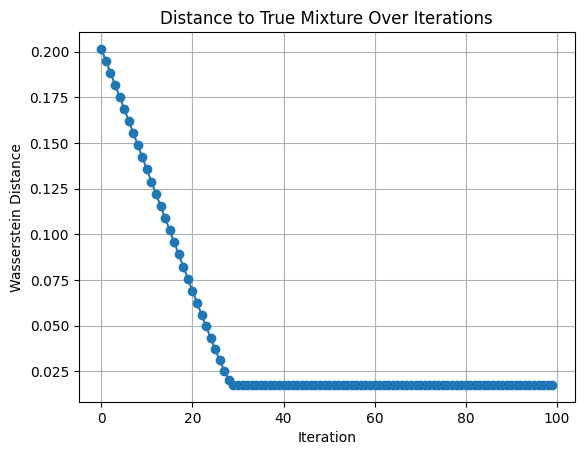

In [107]:
def mirror_descent_torch(learning_rate=1.0, T=100):
    p = torch.tensor([0.5, 0.5], dtype=torch.float64, requires_grad=True)
    history = [p.clone().detach()]
    scores = []

    for _ in trange(T, desc="Mirror Descent (2 weights)"):
        ws = ws_two_mix(p)
        ws.backward()
        scores.append(ws.item())

        # Mirror descent update
        with torch.no_grad():
            w = p * torch.exp(-learning_rate * p.grad)
            p.copy_(w / w.sum())

        p.grad.zero_()  # Reset gradients
        history.append(p.clone().detach())

    return p, history, scores

final_p, traj, score_history = mirror_descent_torch(learning_rate=0.001, T=100)

# plot scores
plt.plot(score_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Wasserstein Distance")
plt.title("Distance to True Mixture Over Iterations")
plt.grid(True)
plt.show()

In [42]:
import ot

N = 2000

def signif_features(spectrum, n_features):
    spectrum_confs = sorted(spectrum.confs, key=lambda x: x[1], reverse=True)[:n_features]
    spectrum_signif = spectrum.copy()
    spectrum_signif.confs = spectrum_confs
    spectrum.normalize()
    return spectrum_signif

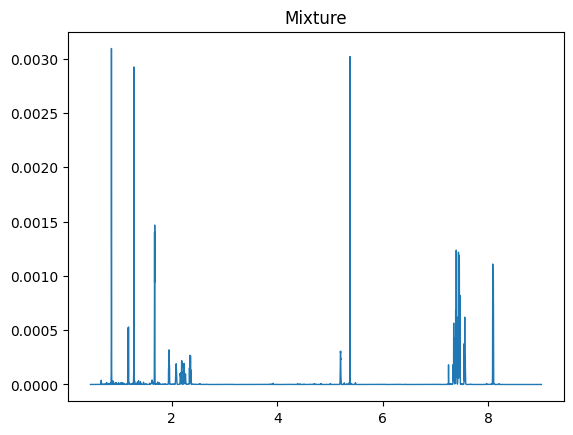

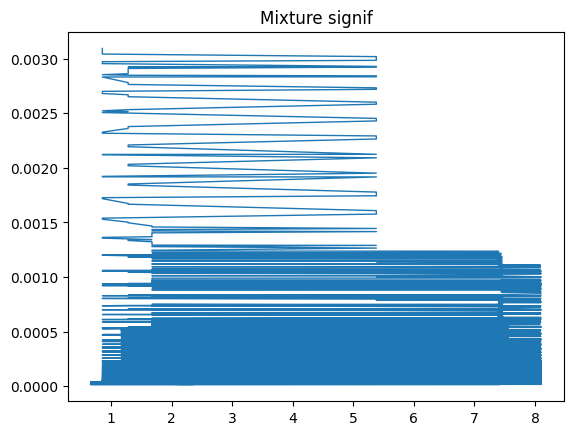

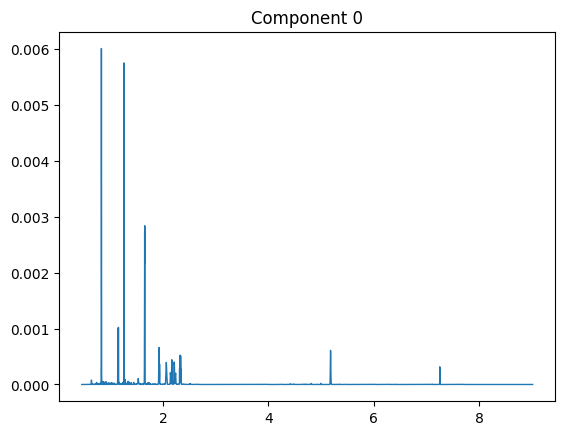

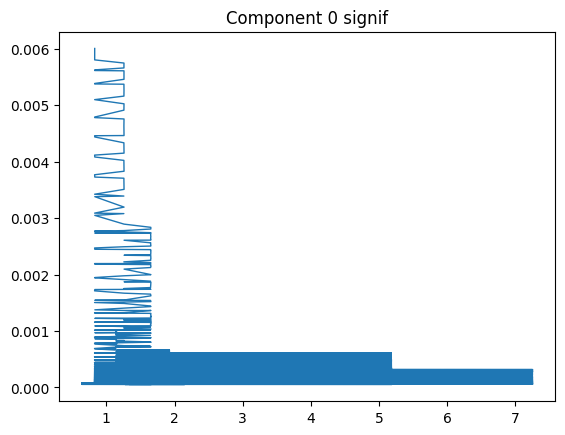

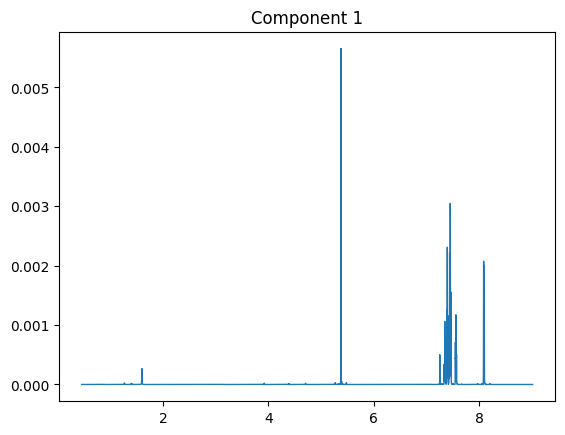

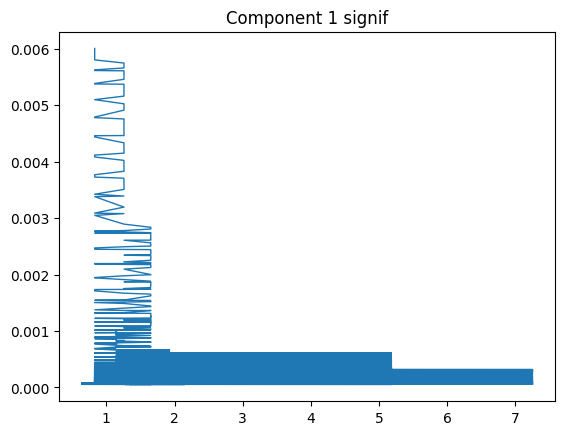

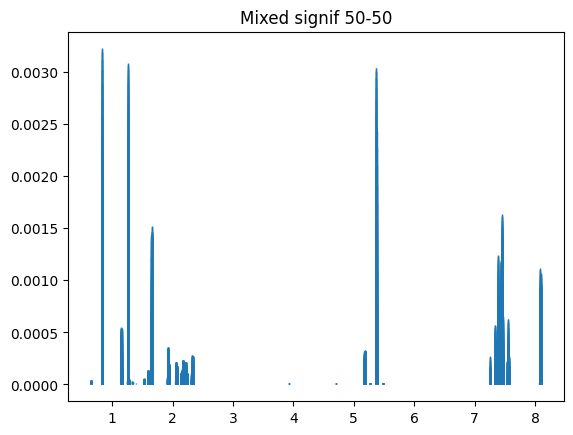

In [53]:
spectra_signif = [None] * 2
spectra_signif[0] = signif_features(spectra[0], N)
spectra_signif[1] = signif_features(spectra[1], N)
mix_signif = signif_features(mix, 2*N)

plt.title("Mixture")
mix.plot(profile=True)
plt.title("Mixture signif")
mix_signif.plot(profile=True)
for i, sp in enumerate(spectra):
    plt.title("Component " + str(i))
    sp.plot(profile=True)
    plt.title("Component " + str(i) + " signif")
    spectra_signif[0].plot(profile=True)
given_p = np.array([0.5, 0.5])
given_mix = Spectrum.ScalarProduct([spectra_signif[0], spectra_signif[1]], given_p)
given_mix.normalize()
plt.title("Mixed signif 50-50")
given_mix.plot()


In [40]:
def cost_matrix(spectrum1, spectrum2):
    vals1 = [val for val, _ in spectrum1.confs]
    vals2 = [val for val, _ in spectrum2.confs]
    
    cost = np.zeros((len(vals1), len(vals2)))
    
    for i, v1 in enumerate(vals1):
        for j, v2 in enumerate(vals2):
            cost[i, j] = abs(v1 - v2)
    
    return cost

# print(cost_matrix(spectra_signif[0], spectra_signif[1]))

In [45]:
a = np.array([p for _, p in spectra_signif[0].confs])
b = np.array([p for _, p in spectra_signif[1].confs])
M = cost_matrix(spectra_signif[0], spectra_signif[1])

print(np.round(ot.unbalanced.lbfgsb_unbalanced2(a, b, M, reg=0, reg_m=5, reg_div='kl', regm_div='tv'), 2))

2.53


Mirror Descent (2 weights):   0%|          | 0/40 [00:00<?, ?it/s]

Mirror Descent (2 weights): 100%|██████████| 40/40 [01:34<00:00,  2.36s/it]


Final weights:
  comp1 = 0.1319
  comp2 = 0.8681


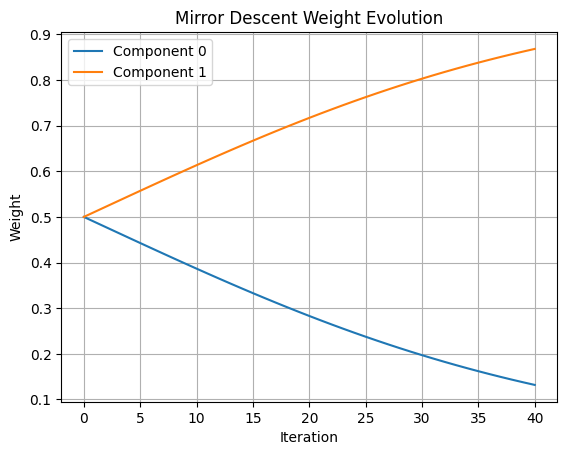

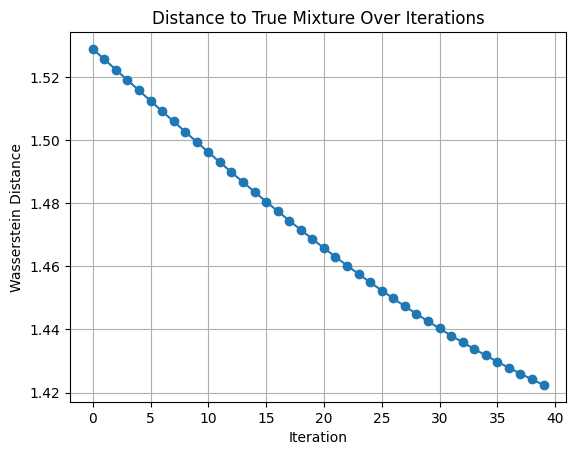

In [52]:
import matplotlib.pyplot as plt
from tqdm import trange

def calculate_gradient_ot(mix, comp0, comp1, p, epsilon=1e-5):
    delta = epsilon

    p_plus = np.array([p[0] + delta, p[1] - delta])
    p_minus = np.array([p[0] - delta, p[1] + delta])

    p_plus = np.clip(p_plus, 1e-6, 1)
    p_plus /= p_plus.sum()

    p_minus = np.clip(p_minus, 1e-6, 1)
    p_minus /= p_minus.sum()

    sp_plus = Spectrum.ScalarProduct([comp0, comp1], p_plus)
    sp_minus = Spectrum.ScalarProduct([comp0, comp1], p_minus)

    sp_plus.normalize()
    sp_minus.normalize()

    # grad = (mix.WSDistance(sp_plus) - mix.WSDistance(sp_minus)) / (2 * epsilon)

    a = np.array([p for _, p in mix.confs])
    b1 = np.array([p for _, p in sp_plus.confs])
    b2 = np.array([p for _, p in sp_minus.confs])
    M1 = cost_matrix(mix, sp_plus)
    M2 = cost_matrix(mix, sp_minus)

    ws_plus = ot.unbalanced.lbfgsb_unbalanced2(a, b1, M1, reg=0, reg_m=5, reg_div='kl', regm_div='tv')
    ws_minus = ot.unbalanced.lbfgsb_unbalanced2(a, b2, M2, reg=0, reg_m=5, reg_div='kl', regm_div='tv')

    grad = (ws_plus - ws_minus) / (2 * epsilon)
    # Gradient of p[1] is -grad because p[1] = 1 - p[0]
    grad_vec = np.array([grad, -grad])

    return grad_vec


def mirror_descent_ot(
    mix, comp0, comp1, learning_rate=1.0, T=100, epsilon=1e-5
):
    p = np.array([0.5, 0.5])
    history = [p.copy()]
    scores = []

    for _ in trange(T, desc="Mirror Descent (2 weights)"):
        estimated_mix = Spectrum.ScalarProduct([comp0, comp1], p)
        estimated_mix.normalize()
        # ws = mix.WSDistance(estimated_mix)
        a = np.array([p for _, p in mix.confs])
        b = np.array([p for _, p in estimated_mix.confs])
        M = cost_matrix(mix, estimated_mix)
        ws = ot.unbalanced.lbfgsb_unbalanced2(a, b, M, reg=0, reg_m=5, reg_div='kl', regm_div='tv')
        scores.append(ws)

        grad_vec = calculate_gradient_ot(mix, comp0, comp1, p, epsilon)

        w = p * np.exp(-learning_rate * grad_vec)
        p = w / w.sum()

        history.append(p.copy())

    return p, np.array(history), np.array(scores)


# Run mirror descent
# mix.normalize()
# spectra[0].normalize()
# spectra[1].normalize()

final_p, traj, score_history = mirror_descent_ot(
    mix_signif, spectra_signif[0], spectra_signif[1], learning_rate=0.08, T=40
)

# estimated_mix = Spectrum.ScalarProduct([spectra[0], spectra[1]], final_p)
# estimated_mix.normalize()

# ws_dist = mix.WSDistance(estimated_mix)

# given_p = np.array([0.393072, 0.606928])
# given_mix = Spectrum.ScalarProduct([spectra[0], spectra[1]], given_p)
# given_mix.normalize()
# ws_dist_given = mix.WSDistance(given_mix)

# Print results
print("\nFinal weights:")
print(f"  comp1 = {final_p[0]:.4f}")
print(f"  comp2 = {final_p[1]:.4f}")
# print(f"\nFinal Wasserstein distance to true mixture: {ws_dist:.6f}")
# print(
#     f"\nWasserstein distance for given mixture (0.393072, 0.606928): {ws_dist_given:.6f}"
# )

plt.plot(traj[:, 0], label="Component 0")
plt.plot(traj[:, 1], label="Component 1")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.title("Mirror Descent Weight Evolution")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(score_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Wasserstein Distance")
plt.title("Distance to True Mixture Over Iterations")
plt.grid(True)
plt.show()